### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import instructor
import inspect
import json

from utils.utils import get_tool_descriptions, format_ai_message

/Users/hanlinyang/Projects/AI/ai_bootcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [3]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [4]:
def retrieve_data(query, qdrant_client, k=5):
    query_embedding = get_embedding(query)
    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search-v2",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(text=query, model="Qdrant/bm25"),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k
    )

    retrieved_context_ids = []
    retrieved_context= []
    similiarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload['parent_asin'])
        retrieved_context.append(result.payload['description'])
        similiarity_scores.append(result.score)
        retrieved_context_ratings.append(result.payload['average_rating'])

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "similiarity_scores": similiarity_scores,
        "retrieved_context_ratings": retrieved_context_ratings
    }

In [5]:
query = "can I get a tablet"

In [6]:
answer = retrieve_data(query, qdrant_client, k=10)

In [7]:
answer

{'retrieved_context_ids': ['B09BNWM4L8',
  'B0B2RK8PHB',
  'B0B4SN9K1T',
  'B0B1QG47W6',
  'B0C697WS8L',
  'B0B6ZZH83Y',
  'B0BCDYMF5L',
  'B09PTSR7TK',
  'B09QS7Z919',
  'B0BK935JV7'],
 'retrieved_context': ['Case for 8 Inch Tablet (10th Generation,2020 Release)-Dinines Lightweight Shockproof Kids Case Cover for 8 inch Tablet. NEW DESIGN-Specially designed for All New 8 inch tablet and 8 plus tablet (8" Display,12th/10th Generation, 2022/2020 release)PRECISE OPENINGS-Cut outs for easy access to all-new 8 inch tablet & 8 plus tablet buttons, ports, speakers and rear-camera. When installing, remove the black frame first.Raised screen bezel edges for extra protection when fallLIGHTWEIGHT-Made of durable & lightweight, colorful, sturdy, child friendly and kid safe EVA foam to guard your H D 8 tablet, get it to match any baby, boy, girl, toddler, child, teen of any age groupSHOCKPROOF-Constructed from impact-resistant EVA material, drop protection and impact-resistance safeguarding your de

### Multi-Intent Questions

In [8]:
query = "Can I get a tablet for my kid, a watch for my wife, and a laptop for myself?"

In [9]:
answer = retrieve_data(query, qdrant_client, k=10)

In [10]:
answer

{'retrieved_context_ids': ['B0B4SN9K1T',
  'B0B1QG47W6',
  'B09PTSR7TK',
  'B0BK935JV7',
  'B09TSQXTYZ',
  'B0B2J2JVDF',
  'B0BQCHJJ2X',
  'B0BVLDTNCB',
  'B0BLTXYYF1',
  'B0C45PV7JX'],
 'retrieved_context': ["Wainyok Kids Tablet, 7 inch Eye Protection IPS Screen, 2GB 16GB WiFi Tab, Dual Camera, Bluetooth & Kids-Proof Case Android11 Tablet. 【Perfect Tablet for Kids】 The kids edition tablet build-in high-performance quad-core processor and Android 11 system. offers access to a range of age-appropriate and up to date fun content including games, videos, paintings, and educational apps. It's an ideal Kid's gift for Christmas, Thanksgiving, birthday【High-end Configuration】 The full-featured tablets for kids receives good appraisal for its well-equipped components. The kid tablet is composed with quad core CPU, latest Android 11 system, 1024x600 IPS HD display screen, Wifi, Bluetooth, dual camera, touchscreen, 2GB RAM and 16GB ROM. Kids will get an all-in-one powerful device【Fantastic Exper

In [29]:
class QueryExpandResponse(BaseModel):
    statements: List[str]

In [24]:
def expand_query_node(query: str) -> dict:

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand a user's query into multiple queries that can be used to search for products in the database.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    prompt = Template(prompt_template).render(query=query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=QueryExpandResponse,
        temperature=0.5
    )
    
    return {
        "queries": response.statements
    }
    

In [25]:
answer = expand_query_node(query)

In [26]:
answer

{'queries': ['tablets suitable for kids',
  'watches for women',
  'laptops for personal use']}

### LangGraph

#### Query Expansion (Sequential Execution)

In [27]:
class State(BaseModel):
    expanded_queries: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

##### Query Expansion / Rewriting Node

In [42]:
class QueryExpandResponse(BaseModel):
    expanded_queries: List[str]

In [43]:
@traceable(
    name="expand_query_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)

def expand_query_node(state: State) -> dict:

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand a user's query into multiple queries that can be used to search for products in the database.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    prompt = Template(prompt_template).render(query=state.initial_query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=QueryExpandResponse,
        temperature=0.5
    )
    
    return {
        "expanded_queries": response.expanded_queries
    }    

#### Retriever Node

In [66]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever",
)
def retrieve_data(query, k=5):

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)
    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search-v2",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(text=query, model="Qdrant/bm25"),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k
    )

    retrieved_context_ids = []
    retrieved_context= []
    similiarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload['parent_asin'])
        retrieved_context.append(result.payload['description'])
        similiarity_scores.append(result.score)
        retrieved_context_ratings.append(result.payload['average_rating'])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context

@traceable(
    name="retrieve_node",
    run_type="retriever",
)
def retrieve_node(state: State) -> dict:

    retrieved_context = []

    for query in state.expanded_queries:
        answer = retrieve_data(query, k=5)
        retrieved_context.append(answer)
    
    return {
        "retrieved_context": retrieved_context
    }

#### Aggregator Node

In [67]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="The final answer to the user's question")

In [68]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)

def aggregator_node(state: State) -> dict:

    preprocessed_context =  "\n".join(state.retrieved_context)

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and retured with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

<Question>
{{ question }}
"""

    template = Template(prompt_template)
    
    prompt = template.render(
        preprocessed_context=preprocessed_context,
        question=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=AggregatorResponse,
        temperature=0.5
    )
    
    return {
        "answer": response.answer
    }    

In [69]:
workflow = StateGraph(State)

workflow.add_node("expand_query_node", expand_query_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "expand_query_node")
workflow.add_edge("expand_query_node", "retrieve_node")
workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()


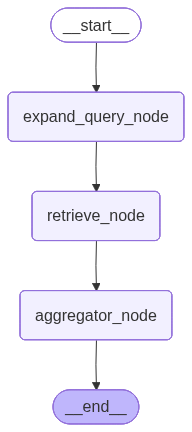

In [70]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [71]:
query

'Can I get a tablet for my kid, a watch for my wife, and a laptop for myself?'

In [72]:
initial_satate = {
    "initial_query": query
}

In [73]:
result = graph.invoke(initial_satate)

In [74]:
result

{'expanded_queries': ['tablet for kids',
  'smartwatch for wife',
  'laptop for personal use'],
 'retrieved_context': ['- ID: B0B4SN9K1T, rating: 3.5, description: Wainyok Kids Tablet, 7 inch Eye Protection IPS Screen, 2GB 16GB WiFi Tab, Dual Camera, Bluetooth & Kids-Proof Case Android11 Tablet. 【Perfect Tablet for Kids】 The kids edition tablet build-in high-performance quad-core processor and Android 11 system. offers access to a range of age-appropriate and up to date fun content including games, videos, paintings, and educational apps. It\'s an ideal Kid\'s gift for Christmas, Thanksgiving, birthday【High-end Configuration】 The full-featured tablets for kids receives good appraisal for its well-equipped components. The kid tablet is composed with quad core CPU, latest Android 11 system, 1024x600 IPS HD display screen, Wifi, Bluetooth, dual camera, touchscreen, 2GB RAM and 16GB ROM. Kids will get an all-in-one powerful device【Fantastic Experience】 This new version kids tablet will pre

In [79]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for your wife, and a laptop for yourself from the available products. Here are detailed options:

Tablet for Kids:
- SANNUO K708 Kids Tablet
  - 7 inch display with 1024x600 IPS HD screen
  - Android 11 system with quad-core processor
  - 3GB RAM and 32GB ROM, expandable up to 128GB
  - Dual cameras (2MP front, 5MP rear)
  - WiFi, Bluetooth, hotspot connectivity
  - Pre-installed kid-friendly applications
  - Eye protection screen with low blue light technology
  - Shockproof protective pink case with adjustable stand
  - Suitable for ages 2-10
  - 2-year warranty

Smartwatch for Wife:
- Iaret Smart Watch for Women
  - 1.32" HD full touch screen with 360x360 resolution
  - Stylish silver metal frame with 60 zircons
  - Call answering/making, music playback
  - Notifications for SMS and social media
  - AI voice assistant control (Siri, Bixby, Google)
  - Health monitoring: heart rate, blood pressure, blood oxygen, sleep tracking
  - 20 sp

#### Query Expansion (Parallel Execution)

In [90]:
class State(BaseModel):
    expanded_queries: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion / Rewriting Node

In [91]:
class QueryExpandResponse(BaseModel):
    expanded_queries: List[str]

In [ ]:
@traceable(
    name="expand_query_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def expand_query_node(state: State) -> dict:

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand a user's query into multiple queries that can be used to search for products in the database.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    prompt = Template(prompt_template).render(query=state.initial_query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=QueryExpandResponse,
        temperature=0.5
    )
    
    return {
        "expanded_queries": response.expanded_queries
    }    

In [93]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_queries:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

#### Retriever Node

In [ ]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever",
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search-v2",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(text=query, model="Qdrant/bm25"),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state.k
    )

    retrieved_context_ids = []
    retrieved_context= []
    similiarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload['parent_asin'])
        retrieved_context.append(result.payload['description'])
        similiarity_scores.append(result.score)
        retrieved_context_ratings.append(result.payload['average_rating'])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context]
    }

#### Aggregator Node

In [95]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="The final answer to the user's question")

In [96]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)

def aggregator_node(state: State) -> dict:

    preprocessed_context =  "\n".join(state.retrieved_context)

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and retured with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

<Question>
{{ question }}
"""

    template = Template(prompt_template)
    
    prompt = template.render(
        preprocessed_context=preprocessed_context,
        question=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=AggregatorResponse,
        temperature=0.5
    )
    
    return {
        "answer": response.answer
    }    

#### Graph

In [104]:
workflow = StateGraph(State)

workflow.add_node("expand_query_node", expand_query_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "expand_query_node")
workflow.add_conditional_edges(
    "expand_query_node",
    query_expand_conditional_edges
)
workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()


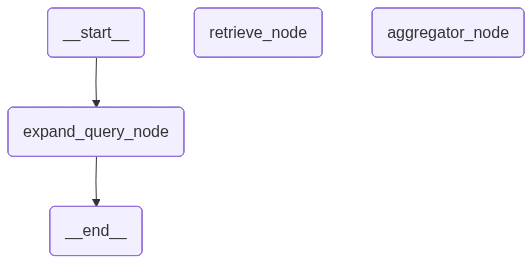

In [105]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [106]:
query

'Can I get a tablet for my kid, a watch for my wife, and a laptop for myself?'

In [107]:
initial_state = {
    "initial_query": query
}
result = graph.invoke(initial_state)
result
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for your wife, and a laptop for yourself from the available products. Here are some detailed options for each:

1. Tablet for your kid:
- SANNUO K708 Kids Tablet
  - 7 inch Android 11 system
  - Quad-Core processor
  - 3GB RAM, 32GB ROM with 128GB expandable
  - Dual cameras (2MP front + 5MP rear)
  - WiFi, Bluetooth, hotspot connectivity
  - Pre-installed kid-friendly applications
  - Eye protection screen with low blue light technology
  - Shockproof case with adjustable stand
  - 2-year warranty

- PRITOM Kids Tablet
  - 7 inch Android 11
  - Quad-Core processor
  - 2GB RAM, 32GB ROM expandable
  - Dual cameras
  - WiFi, Bluetooth
  - Parental control and pre-installed educational apps
  - Kid-proof silicone case with stand
  - 1-year warranty

2. Watch for your wife:
- Iaret Smart Watches for Women
  - 1.32" HD full touch screen (360*360)
  - Stylish silver metal frame with zircons
  - Call receiving/dialing, music playback
  - Heart 